# Определение стоимости автомобилей

In [ ]:
pip install pandas-profiling

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Чтение и первичный анализ данных

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas_profiling 

from scipy.spatial import distance
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder



Константы

In [ ]:
RANDOM_STATE = 12345

Скрытие предупреждений

In [ ]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты и настройки на месте

Прочитаем данные

In [ ]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

In [ ]:
data.tail()

In [ ]:
data.info()

**Признаки**
DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
NotRepaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
Целевой признак
Price — цена (евро)


In [ ]:
data.duplicated().sum()

In [ ]:
data.describe()

In [ ]:
#sns.pairplot(data, hue="Price")

In [ ]:
#data.corr()

Так, у нас обратная корреляция с пробегом: -0.333199 - неудивительно. А прямая с датами регистрации, но есть ощущение, что их бы нужно объединить, то есть месяц рассматривать как продолжение года, а не отдельную цифру. Хотя кто знает, может быть люди не любят машины зарегистрированные в мае, мол, намаешься, или есть другие причины. Также есть пик по индексам. Машины с рублёвки?

Выполнив проверку - закомментим ячейки выше для ускорения расчётов. Теперь это отражено на картинках ниже:

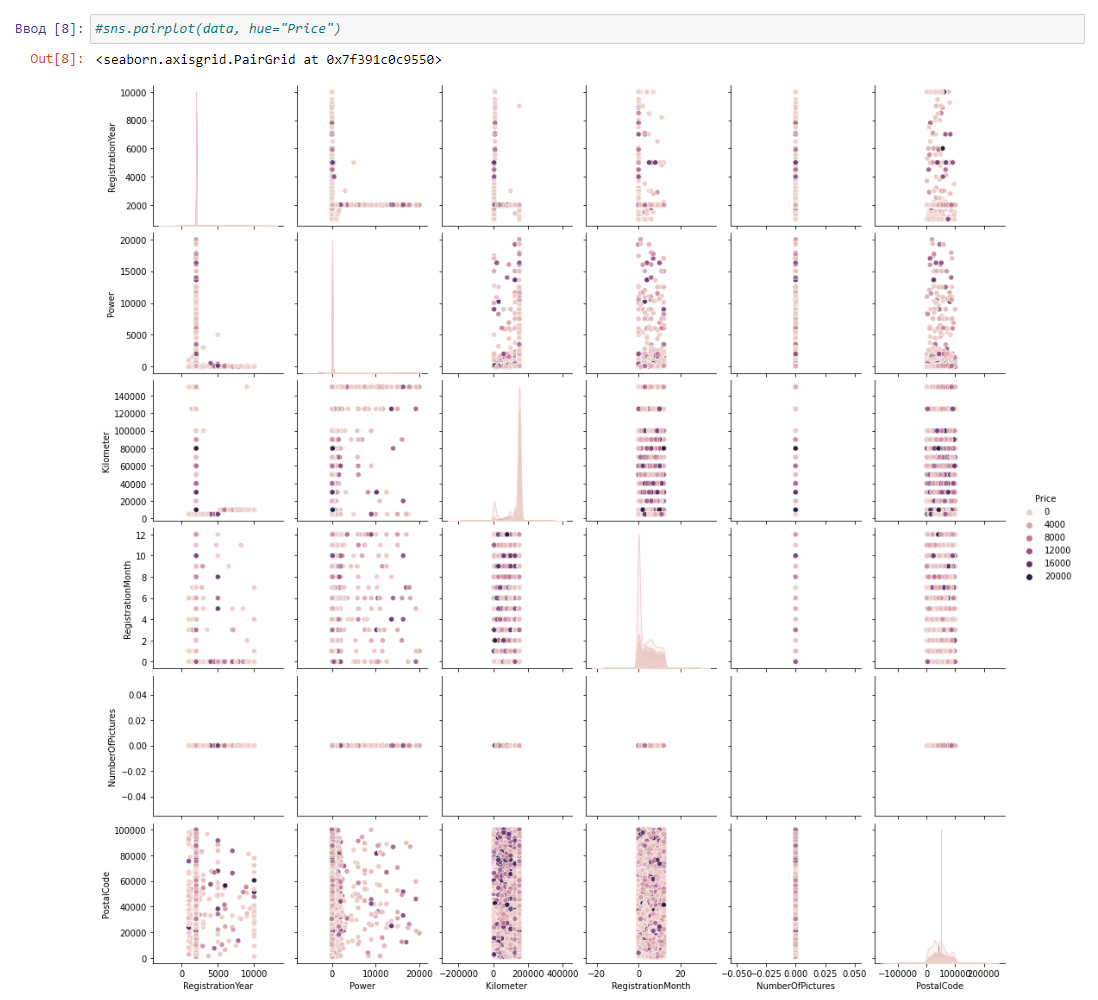

Корреляция в цифрах:

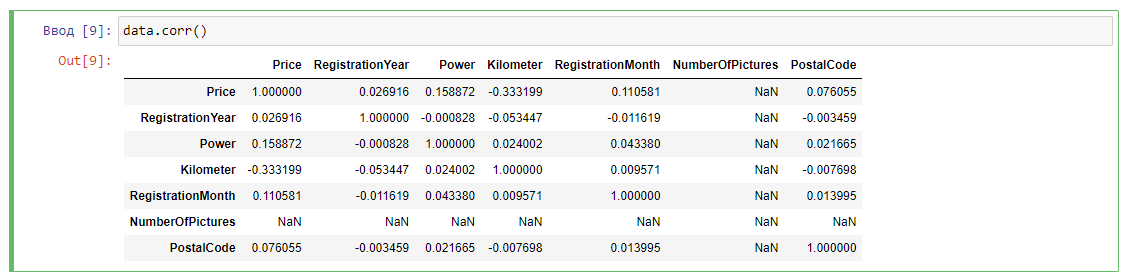

### Заполнение пропусков

In [ ]:
def gaps(datafile):
    gap_columns = []
    gaps_percentage = []
    for column in datafile.columns:
        if datafile[column].count() < datafile.shape[0]:
            gap_columns.append(column)
            gaps_percentage.append(round((datafile.shape[0]-datafile[column].count())/datafile.shape[0]*100, 2))
    full_columns = []
    
    for column in datafile.columns:
        if datafile[column].count() == datafile.shape[0]:
            full_columns.append(column)
            
    gaps_text = ('Таблица представляет собой массив из ' + str(datafile.shape[1]) 
                 + ' столбцов и '+ str(datafile.shape[0]) + ' строк. ' +
                'Таблица содержит пропуски в столбцах ' + str(gap_columns) + '. Процент пропусков - ' + str(gaps_percentage) + '% соответственно. Пропуски в ' + str(len(gap_columns)) + ' столбцах из ' + str(datafile.shape[1])
                 +'. Полностью заполнены и не содержат пропусков столбцы ' + str(full_columns) 
                 + ', всего ' + str(len(full_columns)) + ' полностью заполненных столбцов.')
    return gaps_text

print(gaps(data))

Тип двигателя, тип коробки передач, модель машины, тип топлива и данные о ремонте имеют пропуски. От 5,5 до 20%. Потерять пятую часть данных мы себе не можем позволить. Это у нас сведения о ремонте. Я бы предположила, что не указано скорее по отремонтированным машинам, чтобы повысить стоимость. 

Пятипроцентные пропуски выкинем, как находящиеся на пороге уровня существенности. Основной мотив - то, что не зная модель машины практически невозможно делать вывод о стоимости. А также, то, что тут как в "трёх дорогах" О.Генри - какую ни выберешь - приходишь к финишу с потерей примерно 15% данных. 

In [ ]:
data = data.dropna(subset=['Model', 'FuelType' ])

In [ ]:
print(gaps(data))

Число пропусков уменьшилось во всех незаполненных столбцах. Может быть, какие-то битые данные скачались. Заполним отсутствующие сведения о ремонте, коробке и типе двигателя значением tbd - для возможности дальнейшей обработки

In [ ]:
data[['VehicleType', 'Gearbox', 'NotRepaired']] = data[['VehicleType', 'Gearbox', 'NotRepaired']].fillna('tbd')

In [ ]:
data['NotRepaired'].value_counts()

Вот упорно мне кажется, что отсутствие no в этой колонке равно yes. Но посмотрим позже.

In [ ]:
print(gaps(data))

И у нас "всего 16 полностью заполненных столбцов"

Ещё NumberOfPictures у нас выдавала наны, нужно посмотреть, что там внутри:

In [ ]:
data['NumberOfPictures'].value_counts()

In [ ]:
data['NumberOfPictures'].describe()

одни нули. Нам такой столбец ни к чему, он неинформативен. Также ни к чему нам дата обхода роботом - он у нас ходит довольно часто и совпадает с датой DateCreated.

In [ ]:
data = data.drop(['DateCrawled', 'NumberOfPictures'], axis=1)

Я также не уверена, что месяц регистрации автомобиля является ценной информацией. Но попробуем присмотреться:

In [ ]:
#data['RegDate'] = pd.to_datetime(data['RegistrationYear'], format='%Y-%m') + pd.to_datetime(data[data['RegistrationMonth']!= 0]['RegistrationMonth'], format='%Y-%m')

In [ ]:
data['reg_date'] = data['RegistrationYear'] + data['RegistrationMonth']/ 12

In [ ]:
data['reg_date'].corr(data['Price'])

Ок, корреляция стала выше, чем просто у года, заменим нашей новой датой. Уберем старые год и месяц  регистрации, и дату последнего просмотра.

In [ ]:
data = data.drop(['RegistrationYear', 'RegistrationMonth', 'LastSeen', 'DateCreated'], axis=1)

In [ ]:
data.duplicated().sum()

Дубликатов стало больше. Без развернутой даты ряд строк считается одинаковыми. Оставляем без изменений.

In [ ]:
print(gaps(data))

На индекс ещё нужно взглянуть:

In [ ]:
data['PostalCode'].value_counts()

У нас есть автомобили из редких мест и из распространённых. Так как у нас присутствовал пик на каких-то индексах, посмотрим ещё:

In [ ]:
data.plot(x='PostalCode', y='Price', kind='scatter', alpha=0.2, figsize = (12, 10))

Да, вобщем и целом, всё более-менее однородно. 

In [ ]:
data_piv_pc = data.pivot_table(index='PostalCode', values='Price', aggfunc='mean')
data_piv_pc.describe()

In [ ]:
data_piv_pc[data_piv_pc['Price']> 12000].value_counts().sum()

In [ ]:
data.plot(
    kind='hist',
    y='Price',
    bins = 20,
    figsize =(12,8)
)


У нас явные лидеры, как в одну, так и в другую сторону. Попробуем добавить дополнительный столбец с категорией группы индексов по цене.

In [ ]:
data_piv_pc[data_piv_pc['Price'] < 1000].count()

In [ ]:
data_piv_pc[data_piv_pc['Price'] < 2000].count()

In [ ]:
data_piv_pc[data_piv_pc['Price'] < 2500].count()

In [ ]:
data_piv_pc[data_piv_pc['Price'] > 12000].count()

Да, у нас есть депрессивные регионы. Но вводить доп категории для индексов мы не будем, поскольку тестовые данные их содержать не будут.

### Анализ выбросов

In [ ]:
data.describe()

Мы видим некоторые странности. Первое, что бросается в глаза - нулевая цена. Да, у нас не было пропусков в цене, но нули - те же пропуски, поскольку дарение не предполагается.

In [ ]:
data[data['Price']== 0].value_counts().sum()

In [ ]:
data[data['Price']== 0].value_counts().sum()/data.shape[0]*100

Два процента нулей - придётся удалить.

In [ ]:
data = data[data['Price'] > 0]

Около-нулевые цены кажутся подозрительными.
 Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных

In [ ]:
data[data['Price'] < 50].value_counts().sum()

In [ ]:
data[data['Price'] < 10].value_counts().sum()

In [ ]:
data[data['Price'] < 5].value_counts().sum()

In [ ]:
data[data['Price'] < 3].value_counts().sum()

In [ ]:
data[data['Price'] < 2].value_counts().sum()

In [ ]:
data[data['Price'] <= 1].value_counts().sum()

In [ ]:
data[data['Price'] <= 100].hist('Price', range = (0,100), bins = 50)
plt.show()


In [ ]:
data = data[data['Price'] > 1]

 Проверка показала, что у нас действительно есть пик, 3726 машины за евро. Тут, конечно, лучше бы специфику знать. Может быть, стоимость владения высока и люди пытаются избавиться от убитых в тотал/ветхих/некондиционных машин. Но немцы практичны, даже за металл могли бы получить больше. Это с одной стороны. А с другой - я не знаю стоимости утилизации, там может быть большой сбор. Но интересно посмотреть без них - удаляю.

Удалены машины стоимостью до 1 евро включительно.

С километражом и индексами - всё прилично, а вот даты подкачали: от 1000 до 9999. Мы знаем, что таблица составлялась в 2016 году, позднее дат быть не может.

In [ ]:
data[data['reg_date']< 1940].count()

In [ ]:
data.query('1940 <= reg_date <= 1950').count()

In [ ]:
display(data.query('1940 <= reg_date <= 1950'))

До 1950 года высок риск того, что год поставлен по ошибке. Не может быть ни опеля кадета, ни сеата с коробкой-автомат такого года выпуска. Так как данных немного = убираем их.

In [ ]:
data = data[data['reg_date'] > 1950]

In [ ]:
data.query('2019 < reg_date').count()

In [ ]:
data.query('2017 < reg_date')

In [ ]:
data.query('2017 < reg_date').describe()

Итак, у нас куча автомобилей с большим пробегом, которые в момент сбора информации ещё даже не встали на учет. Невозможная ситуация. Будем считать, что это всё жертвы опечаток. Так как пробег большой - отнимаем от соответствующих дат регистрации 10 лет. 

In [ ]:
data.loc[data['reg_date'] > 2017, 'reg_date'] -= 10

In [ ]:
data.query('2017 < reg_date').describe()

In [ ]:
data[data['reg_date'] > 2017].count()

Остались те немногие, где дата отличается значительно, например 9999. Может быть, это 1999, а может быть и нет. Учитывая, что таких значений мало - удалим их. Вообще, конечно, это лечится простым запретом даты регистрации больше текущей даты в заполняемой форме. 

In [ ]:
data = data[data['reg_date'] <= 2017]

<div class="alert alert-block alert-success">

<b>Успех:</b> С границами согласен

In [ ]:
print(gaps(data))



<div class="alert alert-block alert-info">
<b>Совет:</b> 
Также еще можно рассмотреть аномалии среди мощностей автомобилей.
</div>


In [ ]:
data['Power'].value_counts()

In [ ]:
data['Power'].describe()

 Проверка показала, что у нас мощность от 0 до 20000 л.с. И я не буду убирать нули в данном случае. Их очень много и у них может быть внутренняя логика - требуется ремонт, или двигатель снят.
Гугл любезно подсказывает мне, что нет машин свыше 5000 л.с. Сайты немного глубже - показывают модели до 1600. Суперкары до 2500. Что у нас - кто его знает. Посчитаем, много ли позиций свыше 1000 л.с.:


In [ ]:
data[data['Power'] > 1000]['Power'].count()



In [ ]:
data = data[data['Power'] <= 1000]

Заключительная подготовка - создаем датафрейм признаков и столбец с целевым признаком:

In [ ]:
features = data.drop(['Price'], axis=1)

In [ ]:
target = data['Price']

Разбиваем их на обучающую и тестовую выборки:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

**Вывод** Таблица содержала собой массив из 16 столбцов и 354369 строк. Таблица содержит пропуски в столбцах ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']. [10.58, 5.6, 5.56, 9.28, 20.08] соответственно Пропуски в 5 столбцах из 16. Полностью заполнены и не содержат пропусков столбцы ['DateCrawled', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'Brand', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], всего 11 полностью заполненных столбцов. Мы удалили строки с пропусками по столбцам 'Model'и 'FuelType', заполнили остальные пропуски и удалили предположительно ненужные столбцы. Получилась таблица из 12 столбцов и 302450 строк. Данные подготовлены для моделей.



<div class="alert alert-block alert-info">
<b>Совет:</b> 
Опять же напомню, про структурированность выводов и выделения ключевых моментов - это важно для оформления проекта

</div>


## Обучение моделей

### RMSE

In [ ]:
from sklearn.metrics import make_scorer

def rmse(target, predictions):
    error = (target - predictions) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

### Dummy модель

Для последующего сравнения мы создадим дамми модель:

In [ ]:
%%time
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)


In [ ]:
%%time
dummy_predictions_train = dummy_regr.predict(features_train)
dummy_predictions_train

In [ ]:
%%time
cross_dm = cross_val_score(dummy_regr, features_train, target_train, cv=5, scoring = rmse_scorer) 
cross_dm.mean()
dummy_predictions = dummy_regr.predict(features_train)
dummy_predictions 

Сравним с расчетным средним:

In [ ]:
target_train.mean()

Собственно, вот. Для оценки качества моделей здесь и далее  применим метрику RMSE:

In [ ]:
dummy_rmse_train = mean_squared_error(target_train, dummy_predictions_train)** 0.5
dummy_rmse_train

In [ ]:
dummy_predictions_test = dummy_regr.predict(features_test)
dummy_predictions 

In [ ]:
dummy_rmse_test = mean_squared_error(target_test, dummy_predictions_test)
dummy_rmse_test

Наш эталон готов. Судя по RMSE - он далёк от совершенства. А мы идём дальше.

### Дерево решений

In [ ]:
features.info()

In [ ]:
numeric = ['VehicleType', 'Gearbox', 'Model', 'FuelType','Brand', 'NotRepaired' ]
encoder = OrdinalEncoder()
encoder.fit(features)
features_ohs = pd.DataFrame(encoder.transform(features), columns=features.columns)
features_train_ohs = pd.DataFrame(encoder.transform(features_train), columns=features_train.columns)
features_test_ohs = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)


features_os = pd.get_dummies(features, drop_first=True)
features_train_os = features_os.loc[features_train.index]
features_test_os = features_os.loc[features_test.index]

#features_train_os = pd.DataFrame(encoder.transform(features_train), columns=features_train.columns)
#features_test_os = pd.DataFrame(encoder.transform(features_test), columns=features_test.columns)


In [ ]:
features_train_os.head()

In [ ]:
ss = StandardScaler()

ss.fit(features_train_os)
#features_train_scaled[numeric] = ss.transform(features_train[numeric])
#features_test_scaled[numeric] = ss.transform(features_test[numeric])
features_train_os = ss.fit_transform(features_train_os)
features_test_os = ss.transform(features_test_os)

ss.fit(features_train_ohs)
features_train_ohs = ss.fit_transform(features_train_ohs)
features_test_ohs = ss.transform(features_test_ohs)

Scaler обучен только на трейне

Страшно подумать, насколько монструозная таблица получилась, но надо - значит, надо!

In [ ]:
best_model = None
best_cross = -20000
best_depth = 0
for depth in range(11, 15): # Проверялись различные диапазоны, выводы ниже.
    model_tr =  DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth) # инициализируйте модель DecisionTreeRegressor с параметром random_state=12345 и max_depth=depth
    model_tr.fit(features_train_ohs, target_train) 
    predictions_train = model_tr.predict(features_train_ohs) 
    cross = cross_val_score(model_tr, features_train_ohs, target_train, cv=5, scoring = rmse_scorer)
    if cross.mean()> best_cross:
        best_model = model_tr
        best_cross = cross.mean()
        best_depth = depth

print("RMSE наилучшей модели на обучающей выборке:", -best_cross, "Глубина дерева:", best_depth)


Делаем несколько прогонов в разных диапазонах.  
От 1 до 10 - RMSE наилучшей модели на обучающей выборке: 2013.2312802190909 Глубина дерева: 9
От 1 до 18 - RMSE наилучшей модели на обучающей выборке: 1104.642360732068 Глубина дерева: 17
От 1 до 23 - RMSE наилучшей модели на обучающей выборке: 565.7232876937156 Глубина дерева: 22
От 20 до 33 - RMSE наилучшей модели на обучающей выборке: 128.18524955500138 Глубина дерева: 32
От 30 до 40 - RMSE наилучшей модели на обучающей выборке: 94.49227615902171 Глубина дерева: 39


И можно с большой долей вероятности утверждать, что модель переобучилась.

Проверим нашу лучшую модель на тесте:

In [ ]:
%%time
model_tr =  DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=best_depth)
model_tr.fit(features_train_os, target_train)

In [ ]:
model_tr

In [ ]:
%%time
predictions_train = model_tr.predict(features_train_os)

In [ ]:
result_tr = mean_squared_error(target_train, predictions_train)**0.5
result_tr

Налицо утечка. На трэйне - чем больше глубина деревьев -  тем лучше, но на тесте есть "дно" по rmse на глубине 13 - и результат лучше при дальнейшем углублении уже не получить.

### Случайный лес

Поиск велся в широком диапазоне, для сокращения времени при проверке - неужное убираю, сокращая диапазон и увеличивая шаг.

In [ ]:
best_model = None
best_est = 0 
best_depth = 0 
best_cross = -25000
best_split = 0
best_leaf = 0
for est in range(34, 35): #был диапазон (1, 52), сокращён до близкого к лучшим значениям
    for depth in range(11,12): #был диапазон (1, 15), сокращён до близкого к лучшим значениям
        for split in range(1,2): #был диапазон (1, 5)
            for leaf in range(1,2): #был диапазон (1, 10)
                model_f = RandomForestRegressor(n_estimators=est, 
                                                max_depth=depth, 
                                                random_state=RANDOM_STATE,  
                                                min_samples_split=split/10,
                                                min_samples_leaf=leaf) 
                model_f.fit(features_train_ohs, target_train)
                prediction_f = model_f.predict(features_train_ohs)
                cross = cross_val_score(model_f, features_train_ohs, target_train, cv=5, scoring = rmse_scorer) 
                if  cross.mean()> best_cross:
                    best_est = est
                    best_depth = depth
                    best_cross = cross.mean()
                    best_split = split
                    best_leaf = leaf
                    best_model = model_f
                    print(cross.mean(), est, depth, split, leaf)
print(best_cross, 'Лучшие гиперпараметры:', best_est,  best_depth, best_split, best_leaf)


C OHE результат лучше, но незначительно, зато время пострадало существенно. Так как это важно - вернула к прежнему варианту.


Лучшая модель в диапазоне число n_estimators от 1 до 51, глубина - от 1 до 20, листьев до 6 - модель с соответствующими параметрами 30 9 1 1, 

In [ ]:
%%time
model_rfr = RandomForestRegressor(n_estimators=34,  max_depth=11,  random_state=RANDOM_STATE )#bootstrap=True, 
model_rfr.fit(features_train_ohs, target_train)



In [ ]:
%%time
predictions_rfr = model_rfr.predict(features_train_ohs)
rmse_rfr = rmse(target_train, predictions_rfr)
rmse_rfr

In [ ]:
del features_ohs
del features_train_ohs
del features_test_ohs

### Линейная регрессия

Двигаемся дальше, следующая у нас по плану - линейная регрессия. Сперва- классика:

In [ ]:
model_l = LinearRegression() # инициализируем модель LinearRegression


In [ ]:
%%time
model_l = LinearRegression()
model_l.fit(features_train_os, target_train) # обучим модель на тренировочной выборке


Проверим предсказания на тренировочной выборке

In [ ]:
%%time
predictions_train_l = model_l.predict(features_train_os) # получим предсказания модели на тестовой выборке
result_train_l = mean_squared_error(target_train, predictions_train_l)**0.5 # посчитаем значение метрики sMAPE
print("RMSE модели линейной регрессии на обучающей выборке :", result_train_l)

In [ ]:
%%time
predictions_test_l = model_l.predict(features_test_os) # получим предсказания модели на тестовой выборке
result_test_l = mean_squared_error(target_test, predictions_test_l)**0.5 # посчитаем значение метрики sMAPE
print("RMSE модели линейной регрессии на тестовой выборке :", result_test_l)



И наш результат на линейной регрессии хуже, RMSE модели линейной регрессии на обучающей выборке : 3055.783, на тестовой выборке : 3049.24. Не проходит в лимит 2500. Что же, двинемся дальше.

### Линейная регрессия ручная SGD 

Может быть, в "ручном" режиме получится лучше? Проверим:

In [ ]:
%%time
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0] # копируем вектор w, чтобы его не менять
                reg = 2 * w.copy()
                reg[0] = 0 
                gradient += self.reg_weight * reg 
                
                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0



<div class="alert alert-block alert-success">

<b>Успех:</b>  Хорошая практика

In [ ]:
del features

Чтобы сравнить гребневую регрессию с линейной, начнём с веса регуляризации, равного 0. Затем добавим
обучение с его различными значениями.
проверенные значения [0.0, 0.001, 0.005, 0.1, 1.0, 10.0], rmse - 1.341815057500555e+57, min - 2998.5 при рег. - 1.
[-0.001, -0.00080, -0.0012, -0.0015] #0.01, -0.05, -0.1,  -1.0, -2.0]

И руками мы добились результатов ещё хуже. Предполагаемый минимум рядом с единицей? Проверим:

In [ ]:
regs = [0.48] # 0.55, 0.6]#  -1.0, -2.0]
for reg in regs:
    print("Регуляризация:", reg)
    model_lrh = SGDLinearRegression(0.01, 10, 100, reg)
    model_lrh.fit(features_train_os, target_train)
    pred_train_lrh = model_lrh.predict(features_train_os)
    pred_test_lrh = model_lrh.predict(features_test_os)
    result_train_lrh = mean_squared_error(target_train, pred_train_lrh)**0.5
    result_test_lrh = mean_squared_error(target_test, pred_test_lrh)**0.5
    print("Регуляризация: ", reg, "RMSE обучающая: ",  result_train_lrh.round(5))
    #print("Регуляризация: ", reg, "RMSE тест: ",  result_test_lrh.round(5))
    print()


ч Регуляризация теперь котируется положительная. 
Регуляризация:  0.5 RMSE обучающая:  2803.83007
Регуляризация:  0.9 RMSE обучающая:  2961.19681
Регуляризация:  1.1 RMSE обучающая:  3034.677

Минимум где-то между, при регуляризации 0,48 - 2795.7, но он далёк от идеала.

Так, чуть лучше - при регуляризации -0.001. Посмотрим рядом

Новый рекорд на -0.0015. Продолжаем подбор

Результат удручающий, мы полируем сотые доли, а нужно сдвинуться на пятьсот. Прекращаем попытки и идём в бустинговые модели, Зафиксировав, что получилось:

In [ ]:
%%time
model_lrh = SGDLinearRegression(0.01, 10, 100, 0.48)
model_lrh.fit(features_train_os, target_train)


In [ ]:
%%time

pred_train_lrh = model_lrh.predict(features_train_os)
rmse_train_lrh = rmse(target_train, pred_train_lrh)
rmse_train_lrh


### Градиентный бустинг с CatBoost

Мы наконец-то можем иcпользовать данные без обработки - никакого OE и масштабирования, чистый вид!

In [ ]:
cat_features = ['VehicleType', 'Gearbox','Model',  'FuelType', 'Brand', 'NotRepaired']


In [ ]:
%%time
model_cat = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat_features, loss_function="RMSE", iterations=300)
model_cat.fit(features_train, target_train,verbose=10, plot=True)

In [ ]:
%%time
predictions_cat_train = model_cat.predict(features_train)
rmse_cat_train = rmse(target_train, predictions_cat_train)
print("RMSE градиентного бустинга с CatBoost на обучении:", rmse_cat_train)


Красиво. Были у нас модели с RMSE и пониже на трэйне, но, как мы помним, - переобученные. А что с тестом

Достойный результат. Интересно, а если бы  у нас не было возможности использовать категориальные данные, на обработанной базе как он себя покажет? Так сказать, в сопоставимых условиях с остальными:

Примерно сопоставимо, смотрим тест:

Без обработки базы он даже лучше справляется.

RMSE градиентного бустинга с CatBoost, тест: 1603.393. Посмотрим следующую модель

### Градиентный бустинг с LGBMRegressor

In [ ]:
%%time
model_lgb = LGBMRegressor(random_state=RANDOM_STATE)
model_lgb.fit(features_train_os, target_train)


In [ ]:
%%time
predictions_lgb_train = model_lgb.predict(features_train_os)
rmse_lgb_train = rmse(target_train, predictions_lgb_train)
print("RMSE градиентного бустинга с LGBMRegressor на обучении:", rmse_lgb_train)


Итак, RMSE градиентного бустинга с LGBMRegressor на обучении: 1682.8996. Проверяем на тестовой выборке:

## Анализ моделей

Представим результаты нашей работы в таблице, время для сопоставимости выражено в миллисекундах. Отмечу, что время варьировалось от запуска к запуску, но результаты сопоставимы с представленными.

In [ ]:
data = {'RMSE на обучении ':[dummy_rmse_train, result_tr, rmse_rfr, result_train_l, rmse_train_lrh, rmse_cat_train, rmse_lgb_train],
        'Скорость обучения, ms':[0, 7250, 97000, 47500, 6160, 80000, 22000],
       'Скорость предсказания, ms':[1, 248, 1690, 194, 5, 961, 612]} 
# Creates pandas DataFrame. 
plt = pd.DataFrame(data, index =['Dummy модель', 'Дерево решений', 'Случайный лес', 'Линейная регрессия',
                                 'Линейная регрессия ручная SGD', 'Градиентный бустинг с CatBoost', 'Градиентный бустинг с LGBMRegressor']) 

display(plt)

Вывод Лучший результат RMSE показал Случайный лес, 912.4 на обучении. Но у него же самое большое время обучения и предсказаний. Показанные здесь 1 м 27 с в реальности показались более долгими. Скорее всего, пользователь приложения будет иметь дело только с предсказанием, обучена модель будет раньше. Но нужно, чтобы задержка не показалась пользователю слишком длинной. Следующий на очереди по RMSE - Градиентный бустинг с CatBoost, rmse 1540.5. Время модели  Градиентный бустинг с CatBoost на обучении - 1 м 20 с, а на предсказании -  961 мс. <br> Именно эту модель мы представим заказчику как лучший вариант. Проверим её показатели на тестовой выборке:

После устранения моделей с переобучением, у нас бесспорный лидер -  Градиентный бустинг с CatBoost, RMSE - 1540.5, время обучения - 1м 13 с, время обучения - 788. 

In [ ]:
%%time
predictions_cat_test = model_cat.predict(features_test)
rmse_cat_test = rmse(target_test, predictions_cat_test)
print("RMSE градиентного бустинга с CatBoost, тест:", rmse_cat_test)

**Вывод** Лучший результат по совокупности RMSE и времени работы показал **Градиентный бустинг с CatBoost: на обучении - 1540.5, на тесте - 1607.2**. По времени он также является приемлемым, 279 ms на тесте. 

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей